Before we start, please put your name and ID in following format: <br>
NAME, ?000000000   e.g. 陳琨翔, M094020003

**Your Answer:**   
Hi I'm 朱劭璿, B073040018

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python 3.6.9`, `torch==1.6.0`

In [1]:
!python --version
!pip freeze | grep torch

Python 3.6.9
torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101


# Prepare Data

## Get Data

請先到共用雲端硬碟將檔案`flower_data.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1rTfeCpKXoQXI978QiTWC-AI1vwGvd5SU/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip Data

解壓縮 `flower_data.zip` 後可以發現裡面有兩個資料夾和三個csv檔。

+ `train` : 存有五個資料夾分別是五個種類的花，資料夾內為花的照片。
+ `test` : 資料夾中為未分類之測試集照片。
+ `train.csv` : 讀取 train data 的順序、路徑與圖片所屬花別。
+ `val.csv` : 讀取 validate data 的順序、路徑與圖片所屬花別。
+ `test.csv` : 讀取 test data 的順序、路徑。

其中`train`的圖片3112張，`val`的圖片778章，`test`的圖片433張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [3]:
!unzip -qq ./drive/My\ Drive/Colab\ Notebooks/data/deep_fashion.zip

replace deep_fashion/val/02039.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Loading the dataset


### Custom dataset

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [4]:
import csv
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from sklearn.metrics import f1_score

train_target = 'all'

class FashionData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.category_labels = []
        self.attribute_labels = []
        self.transform = transform
        
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            fieldnames = reader.fieldnames
            for row in reader:
                self.data_list.append(row[fieldnames[0]])
                if mode != 'test':
                    self.category_labels.append(row[fieldnames[1]])
                    mask = list(map(int, row[fieldnames[2]].split()))
                    one_hot = np.zeros(15)
                    one_hot[mask] = 1
                    self.attribute_labels.append(one_hot)

    def __getitem__(self, index):

        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        category_labels = torch.tensor(int(self.category_labels[index]))
        attribute_labels = torch.tensor([int(l) for l in self.attribute_labels[index]])

        return data, category_labels, attribute_labels.float()

    def __len__(self):
        return len(self.data_list)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

Pytorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/docs/stable/torchvision/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

(**Slide.07 page.49**)

In [5]:
from torchvision import transforms
# For TRAIN
resize_dim= 256
image_dim = 224
transforms_train = transforms.Compose([
          transforms.Resize((resize_dim, resize_dim)),
          transforms.RandomCrop(image_dim),
          transforms.RandomHorizontalFlip(0.5),
          transforms.RandomRotation((-45, 45)),
          transforms.ColorJitter(0.1, 0.2, 0.1),
          transforms.ToTensor(),
          transforms.RandomErasing(inplace=True, scale=(0.01, 0.23)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# For VAL, TEST
transforms_test = transforms.Compose([
          transforms.Resize((resize_dim, resize_dim)),
          transforms.CenterCrop((image_dim, image_dim)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [6]:
dataset_train = FashionData('./deep_fashion/train.csv', mode='train', transform=transforms_train)
dataset_val = FashionData('./deep_fashion/val.csv', mode='train', transform=transforms_test)
dataset_test = FashionData('./deep_fashion/test.csv', mode='test', transform=transforms_test)

In [7]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(0)[0].size())
print("The first image's class label in dataset_train :", dataset_train.__getitem__(0)[1])
print("The first image's attribute label in dataset_train :", dataset_train.__getitem__(1)[2])
print("There are", dataset_train.__len__(), "images in dataset_train.")
num_classes = 10 + dataset_train.__getitem__(0)[2].shape[0]
print("num_classes:", num_classes)

The first image's shape in dataset_train : torch.Size([3, 224, 224])
The first image's class label in dataset_train : tensor(1)
The first image's attribute label in dataset_train : tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
There are 39092 images in dataset_train.
num_classes: 25


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [8]:
from torch.utils.data import DataLoader, SubsetRandomSampler

BATCH_SIZE = 64
############# debug #############
dataset_size = len(dataset_train)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
drop = int(np.floor(0.9 * dataset_size))
train_idx = dataset_indices[drop:]
train_sampler = SubsetRandomSampler(train_idx)
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
############# debug #############

# train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

Try to design and train a deep convolutional network from scratch to predict the class label of a flower image. 

You can refer to last assignment about image_classifier, and try to go deep and use more method for better model.

In [9]:
import torchvision.models as models
from torch import nn
from torch import Tensor
from typing import Callable, Any, Optional, List

class ConvBNReLU(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU6(inplace=True)
        )
class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class Head(nn.Module):
    def __init__(self, in_dim, out_dim, block):
        super(Head, self).__init__()
        self.conv = nn.Sequential(block(in_dim, 1000, 1, 1), block(1000, 1000, 1, 1), block(1000, 500, 1, 1))
        self.fc = nn.Sequential(
            nn.BatchNorm1d(500),
            nn.Linear(500, 100, True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(100, out_dim, True))
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).reshape(batch_size, -1)
        out = self.fc(x)
        return out

class Augment_net(nn.Module):
    def __init__(self):
        super(Augment_net, self).__init__()
        self.mobilenet_v2 = nn.Sequential(*list(models.mobilenet_v2(pretrained=True).children())[:-1])
        self.cate_net = Head(1280, 10, InvertedResidual)
        self.attr_net = nn.ModuleList()
        for _ in range(15):
            self.attr_net.append(Head(1280, 1, InvertedResidual))
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.mobilenet_v2(x)
        cate_out = self.cate_net(x)
        attr_out = torch.cat([self.attr_net[i](x) for i in range(15)], dim=1)
        return cate_out, attr_out



In [10]:
model = Augment_net()
if train_target == 'cate':
    for param in model.mobilenet_v2.parameters():
        param.requires_grad = False
    for param in model.attr_net.parameters():
        param.requires_grad = False
elif train_target == 'attr':
    for param in model.mobilenet_v2.parameters():
        param.requires_grad = False
    for param in model.cate_net.parameters():
        param.requires_grad = False
    
model = model.cuda()

log_var_a = torch.tensor([0.0], requires_grad=False, device='cuda')
log_var_b = torch.tensor([0.0], requires_grad=False, device='cuda')

if train_target == 'all':
    log_var_a.requires_grad=True
    log_var_b.requires_grad=True
    # model.load_state_dict(torch.load('cate_model_params.pth'))
    # attr_state_dict = torch.load('attr_model_params.pth')
    # for k, v in model.state_dict().items():
    #     if 'cate_net' in k:
    #         attr_state_dict.update({k: v})
    # model.load_state_dict(attr_state_dict)

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer

In [11]:
mul_cla_criterion = nn.CrossEntropyLoss()
sin_cla_criterion = nn.BCEWithLogitsLoss(reduction='mean')
mul_cla_criterion = mul_cla_criterion.cuda()
sin_cla_criterion = sin_cla_criterion.cuda()

optimizer = torch.optim.Adam([
                {'params': model.mobilenet_v2.parameters()},
                {'params': model.cate_net.parameters()},
                {'params': model.attr_net.parameters()},
                {'params': ([log_var_a] + [log_var_b])}
            ], lr=1e-1, weight_decay=1e-6)

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max)

In [12]:
def train(input_data, model, mul_cla_criterion, sin_cla_criterion):
    model.train()
    cate_loss_list = []
    attr_loss_list = []
    loss_list = []
    total_count = 0
    acc_count = 0
    attr_pred = np.array([])
    attr_gt = np.array([])
    for i, data in enumerate(input_data, 0):
        images, cate_labels, attr_labels = data[0].cuda(), data[1].cuda(), data[2].cuda()
        
        optimizer.zero_grad()
        cate_out, attr_out = model(images)
        weight_a, weight_b = torch.exp(-log_var_a)**2, torch.exp(-log_var_b)**2
        cate_loss = mul_cla_criterion(cate_out, cate_labels)
        weighted_cate_loss = weight_a*cate_loss
        attr_loss = 4*sin_cla_criterion(attr_out, attr_labels) #multiplier=5
        weighted_attr_loss = weight_b*attr_loss
        loss = cate_loss + attr_loss
        weighted_loss = weighted_cate_loss + weighted_attr_loss + log_var_a + log_var_b
        if train_target == 'cate':
            loss = cate_loss
            weighted_loss = weighted_cate_loss
        elif train_target == 'attr':
            loss = attr_loss
            weighted_loss = weighted_attr_loss
            
        weighted_loss.backward()
        optimizer.step()
        
        if i%10 == 0:
            print('batch:', i, 'weights: {:.6f}, {:.6f}'.format(weight_a.item(), weight_b.item()), 'loss: {:.6f}, {:.6f}'.format(weighted_cate_loss.item(), weighted_attr_loss.item()))
        _, cate_predicted = torch.max(cate_out, 1)
        attr_pred = np.append(attr_pred, ((attr_out>0).cpu().detach().numpy().astype(int)))
        attr_gt = np.append(attr_gt, (attr_labels.cpu().detach().numpy().astype(int)))
        total_count += cate_out.shape[0]
        acc_count += (cate_predicted == cate_labels).sum().item()
        cate_loss_list.append(cate_loss.item())
        attr_loss_list.append(attr_loss.item())
        loss_list.append(loss.item())
        
    cate_acc = acc_count / total_count
    attr_acc = f1_score(attr_pred, attr_gt)
    cate_loss = sum(cate_loss_list) / len(cate_loss_list)
    attr_loss = sum(attr_loss_list) / len(attr_loss_list)
    loss = sum(loss_list) / len(loss_list)
    return cate_acc, attr_acc, cate_loss, attr_loss, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [13]:
def val(input_data, model, mul_cla_criterion, sin_cla_criterion):
    model.eval()
    cate_loss_list = []
    attr_loss_list = []
    loss_list = []
    total_count = 0
    acc_count = 0
    attr_pred = np.array([])
    attr_gt = np.array([])
    with torch.no_grad():
        for data in input_data:
            images, cate_labels, attr_labels = data[0].cuda(), data[1].cuda(), data[2].cuda()

            cate_out, attr_out = model(images)
            cate_loss = mul_cla_criterion(cate_out, cate_labels)
            attr_loss = 4*sin_cla_criterion(attr_out, attr_labels) #multiplier=5
            loss = cate_loss + attr_loss
            if train_target == 'cate':
                loss = cate_loss
            elif train_target == 'attr':
                loss = attr_loss

            _, cate_predicted = torch.max(cate_out, 1)
            attr_pred = np.append(attr_pred, ((attr_out>0).cpu().detach().numpy().astype(int)))
            attr_gt = np.append(attr_gt, (attr_labels.cpu().detach().numpy().astype(int)))
            total_count += cate_out.shape[0]
            acc_count += (cate_predicted == cate_labels).sum().item()
            cate_loss_list.append(cate_loss.item())
            attr_loss_list.append(attr_loss.item())
            loss_list.append(loss.item())

    cate_acc = acc_count / total_count
    attr_acc = f1_score(attr_pred, attr_gt)
    cate_loss = sum(cate_loss_list) / len(cate_loss_list)
    attr_loss = sum(attr_loss_list) / len(attr_loss_list)
    loss = sum(loss_list) / len(loss_list)
    return cate_acc, attr_acc, cate_loss, attr_loss, loss



#### Training in a loop
First, I train cate_net and attr_net with only their own gradient enabled respectively.
Then I combine two trained parameter groups and train with all the parameters' gradient enabled.

Category:
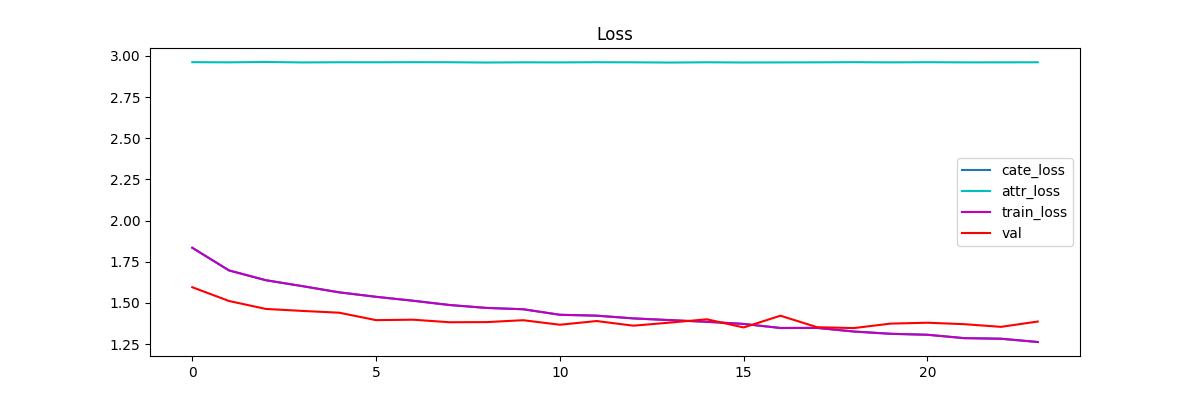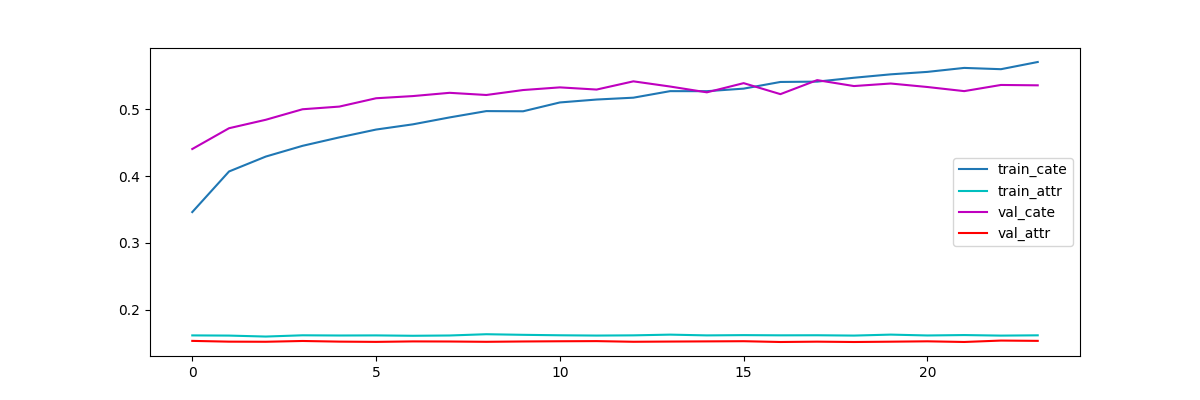

Attribute
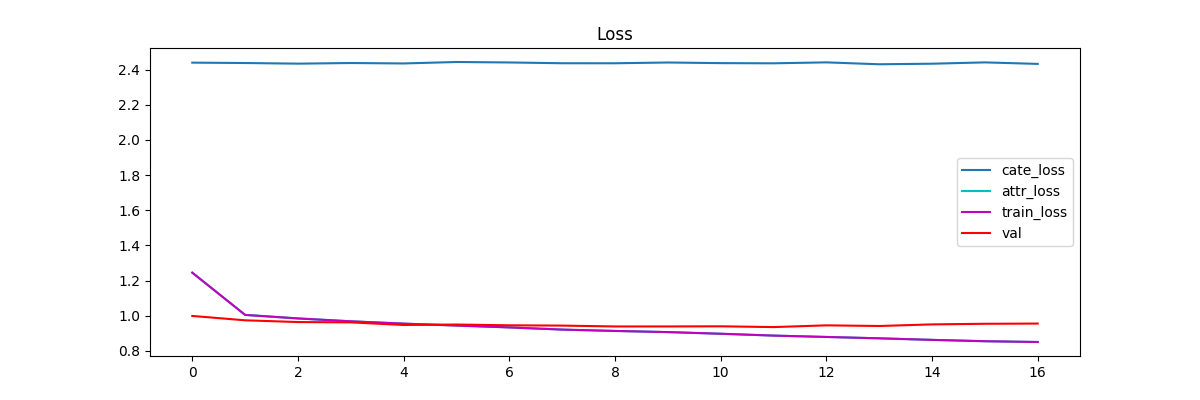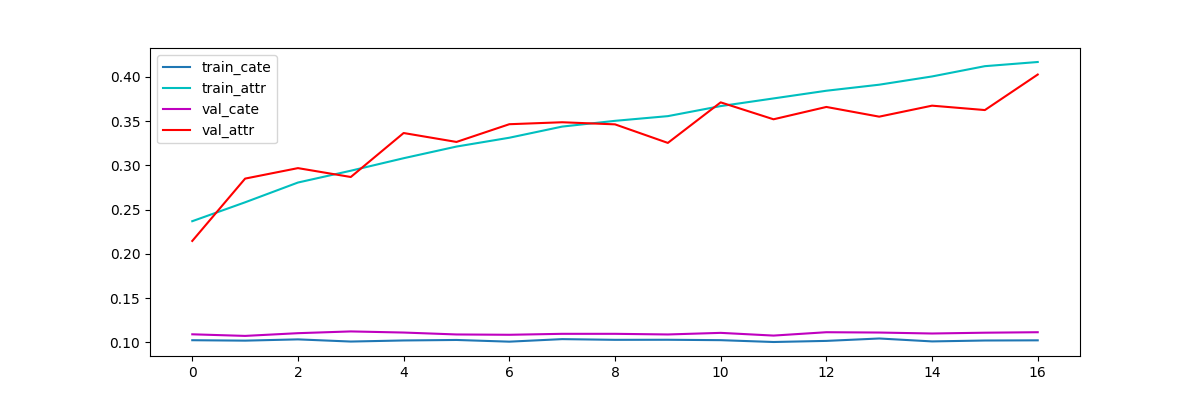

In [14]:
max_epochs = 1
log_interval = 1

train_cate_acc_list = []
train_attr_acc_list = []
cate_loss_list = []
attr_loss_list = []
train_loss_list = []
val_cate_acc_list = []
val_attr_acc_list = []
val_loss_list = []

patience = 0
min_loss = 1000000
best_model = None
best_log_vars = None


print("Start training...")
for epoch in range(1, max_epochs+1):
    train_cate_acc, train_attr_acc, train_cate_loss, train_attr_loss, train_loss = train(train_loader, model, mul_cla_criterion, sin_cla_criterion)
    val_cate_acc, val_attr_acc, val_cate_loss, val_attr_loss, val_loss = val(val_loader, model, mul_cla_criterion, sin_cla_criterion)
    
    train_cate_acc_list.append(train_cate_acc)
    train_attr_acc_list.append(train_attr_acc)
    cate_loss_list.append(train_cate_loss)
    attr_loss_list.append(train_attr_loss)
    train_loss_list.append(train_loss)
    val_cate_acc_list.append(val_cate_acc)
    val_attr_acc_list.append(val_attr_acc)
    val_loss_list.append(val_loss)
    
    if val_loss < min_loss:
        patience = 0
        min_loss = val_loss
        best_model = model.state_dict()
        best_log_vars = (log_var_a, log_var_b)
      
    patience += 1
    if patience > 3: #early stopping
        break
        
    if epoch % log_interval == 0:
        print('')
        print('=' * 40, 'Epoch', epoch, '=' * 40)
        print('Train Cate Acc: {:.6f} Train Attr F1: {:.6f} Train Loss: {:.6f} Cate Loss: {:.6f} Attr Loss: {:.6f}'.format(train_cate_acc, train_attr_acc, train_loss, train_cate_loss, train_attr_loss))
        print('Val Cate Acc: {:.6f} Val Attr F1: {:.6f} Val Loss: {:.6f} Cate Loss: {:.6f} Attr Loss: {:.6f}'.format(val_cate_acc, val_attr_acc, val_loss, val_cate_loss, val_attr_loss))
        
filename = 'model_params.pth'
if train_target == 'cate':
    filename = 'cate_model_params.pth'
elif train_target == 'attr':
    filename = 'attr_model_params.pth'
torch.save(best_model, filename)
with open('log_vars.txt', 'w') as f:
    for item in best_log_vars:
        f.write("%f " % item)

Start training...
batch: 0 weights: 1.000000, 1.000000 loss: 2.560291, 2.972882
batch: 10 weights: 0.168113, 0.219547 loss: 0.598863, 0.368266
batch: 20 weights: 0.082520, 0.152979 loss: 0.205093, 0.224776
batch: 30 weights: 0.100724, 0.212120 loss: 0.252466, 0.292489
batch: 40 weights: 0.169118, 0.349495 loss: 0.436120, 0.483091
batch: 50 weights: 0.235925, 0.423996 loss: 0.644413, 0.576511
batch: 60 weights: 0.220244, 0.378534 loss: 0.588243, 0.494263

======================================== Epoch 1 ========================================
Train Cate Acc: 0.108184 Train Attr F1: 0.062296 Train Loss: 4.376720 Cate Loss: 2.761050 Attr Loss: 1.615670
Val Cate Acc: 0.088097 Val Attr F1: 0.068852 Val Loss: 4.965909 Cate Loss: 2.631762 Attr Loss: 2.334146


#### Visualize accuracy and loss
Nothing, because I didn't train on colab

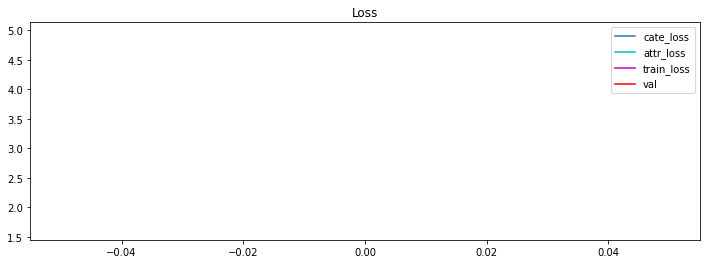

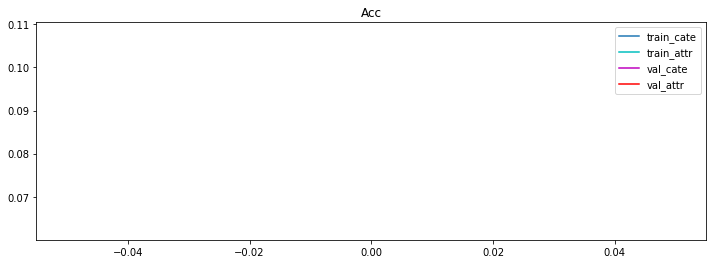

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(cate_loss_list)), cate_loss_list)
plt.plot(range(len(attr_loss_list)), attr_loss_list, c='c')
plt.plot(range(len(train_loss_list)), train_loss_list, c='m')
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['cate_loss','attr_loss' , 'train_loss', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_cate_acc_list)), train_cate_acc_list)
plt.plot(range(len(train_attr_acc_list)), train_attr_acc_list, c='c')
plt.plot(range(len(val_cate_acc_list)), val_cate_acc_list, c='m')
plt.plot(range(len(val_attr_acc_list)), val_attr_acc_list, c='r')
plt.legend(['train_cate', 'train_attr', 'val_cate', 'val_attr'])
plt.title('Acc')
plt.show()

### Predict Result

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a16786b7da97419f9ba90b495dab08aa)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [18]:
model.load_state_dict(torch.load('model_params.pth'))

def predict(input_data, model):
    model.eval()
    cate_output_list = []
    attr_output_list = []
    with torch.no_grad():
        for data in input_data:
            images = data.cuda()
            cate_out, attr_out = model(images)
            _, cate_predicted = torch.max(cate_out, 1)
            attr_predicted = attr_out>=0
            #additional processes to attribute predictions
            attr_str = []
            for i, pred in enumerate(attr_predicted):
                s=''
                if pred.all() == False:
                    pred[torch.argmax(attr_out[i])] = True
                for feature_id in range(15):
                    if pred[feature_id]:
                        s += (str(feature_id)+' ')
                attr_str.append(s)
                
            cate_output_list.extend(cate_predicted.to('cpu').numpy().tolist())
            attr_output_list.extend(attr_str)
    return cate_output_list, attr_output_list 

In [19]:
file_path = dataset_test.data_list
cate_output_list, attr_output_list = predict(test_loader, model)
with open('cate_result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'category_label'])
    writer.writeheader()
    for i, out in enumerate(cate_output_list):
        writer.writerow({'file_path':file_path[i], 'category_label':out})

with open('attr_result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'attribute_label'])
    writer.writeheader()
    for i, out in enumerate(attr_output_list):
        writer.writerow({'file_path':file_path[i], 'attribute_label':out})